# Amazon Personalize 用户细分

Amazon Personalize 提供两种配方，可根据用户对不同产品类别、品牌等的兴趣对用户进行细分。
1. 我们的项目关联配方 `aws-item-affinity` 根据用户对您目录中的单个项目（如电影、歌曲或产品）的兴趣来标识用户。
1. 项目属性关联配方 `aws-item-attribute` 根据目录中项目的属性（如流派或品牌）标识用户。这可以提高营销活动的参与度，通过针对性信息传递来提高保留率。

此笔记本演示如何使用 `aws-item-affinity` 和 `aws-item-attribute` 配方，根据 Amazon Prime Pantry 数据集中用户对杂货产品的偏好来创建用户细分。我们使用一个包含用户-项目交互数据和项目元数据的数据集组。我们使用这些数据集来训练使用这两个配方的解决方案，并批量创建用户细分。


此笔记本将指导您完成以下架构的部署。

![](user_segmentation.png)

正如我们在上面看到的，我们将部署以下资源：
1. S3 存储桶用于存储训练文件，以及我们的推理输入和输出文件
1. 数据集组
1. 两个数据集 – 交互和项目
1. 使用我们的每个新的 User Segmentation 配方配置的两个解决方案和解决方案版本
1. 两个批量推理作业

在我们有了批量推理作业结果之后，我们将对这些结果进行分析

## 加载和预处理数据
我们将首先加载 Prime Pantry 数据集。您需要填写表单才能访问数据文件：

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

引文：

    使用距离标记评论和细粒度方面来证明推荐的合理性
    Jianmo Ni, Jiacheng Li, Julian McAuley
    Empirical Methods in Natural Language Processing (EMNLP), 2019 pdf

In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import boto3
import time
from time import sleep
from lxml import html
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import datetime as dt

In [2]:
data_dir = 'raw_data'
!mkdir $data_dir

!cd $data_dir && \
    wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Grocery_and_Gourmet_Food.json.gz && \
    wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Grocery_and_Gourmet_Food.json.gz

--2021-11-26 02:58:20--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Grocery_and_Gourmet_Food.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 586910426 (560M) [application/octet-stream]
Saving to: ‘Grocery_and_Gourmet_Food.json.gz’

Grocery_and_Gourmet 100%[===================>] 559.72M  83.2MB/s    in 7.0s    

2021-11-26 02:58:27 (80.3 MB/s) - ‘Grocery_and_Gourmet_Food.json.gz’ saved [586910426/586910426]

--2021-11-26 02:58:27--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Grocery_and_Gourmet_Food.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109586529 (105M) [application/octet-stream]
Saving to: ‘meta_Grocery_and_Gourmet_Food.json.gz’

me

### 加载和检查项目元数据
我们首先加载 Prime Pantry 产品的项目元数据，并运行一些命令来查看我们必须使用的内容。

In [9]:
meta=pd.read_json(data_dir + '/meta_Grocery_and_Gourmet_Food.json.gz',lines=True,compression='infer')
#remove duplicated items and items without item title
meta=meta.rename(columns={'asin':'ITEM_ID'}).drop_duplicates(subset=['ITEM_ID'], keep='last')
meta = meta[meta.title.notnull()]
print('After removing items without title: {}'.format(meta.shape))

After removing items without title: (283354, 19)


共有 283,354 条记录和 19 个列

然后，我们格式化项目描述，将其与标题组合以用作文本特征，并仅保留具有此文本特征的项目。

In [10]:
def process_description(description):    
    description = description.replace('<p>&nbsp;</p>', '') # remove &nbsp from the text
    description = description.replace('<p></p>', '') # remove <p></p> from the text
    description = description.replace('<p> </p>', '') # remove <p> </p> from the text
    
    # remove hyper links form the text
    import re
    a_pattern = re.compile('<a.*?>')
    description = re.sub(a_pattern, '', description)
    description = description.replace('</a>', '')
    
    # remove spans from the text
    span_pattern = re.compile('<span.*?>')
    description = re.sub(span_pattern, '', description)
    description = description.replace('</span>', '')
    
    # remove <b> and </b> from the text
    description = description.replace('<b>', '')
    description = description.replace('</b>', '')
    
    # remove .  . and \n from the text
    description = description.replace('\n', '')
    
    # remove HTML
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    description = re.sub(cleanr, '', description)
    
    # remove extra space etc.
    description = ' '.join(description.split())
    
    # specifics for Amazon dataset
    description = description.replace('.  .', '')
    
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(description)
    text = soup.find_all(text = True)
    
    for index, t in enumerate(text):
        if t[-1] != '.':
            text[index] += '.'
    
    return ' '.join(text).strip()
meta['description']=meta.apply(lambda x:process_description(x['title']+' '+' '.join(x['description'])),axis=1)
meta=meta[meta['description'].apply(len)>0]
print("Done cleaning the description")

Done cleaning the description


然后，我们将格式化项目的价格，删除并重命名数据集列，并打印元数据的数据框形状

In [11]:
#formatting price
def convert_price(row):
    v = str(row['price']).strip().replace('$', '')
    if v == '' or not v.lstrip('-').replace('.', '').isdigit():
        return np.nan
    return v
meta['price'] = meta.apply(convert_price, axis=1)
meta=meta[['category','brand','main_cat','description','price','ITEM_ID']].set_index('ITEM_ID')
meta.rename(columns = {'category':'CATEGORY', 'brand':'BRAND', 'main_cat':'MAIN_CAT',
                              'price':'PRICE', 'description': 'DESCRIPTION'}, inplace = True)
print('Items with non-empty description+title: {}'.format(meta.shape))

Items with non-empty description+title: (283352, 5)


我们没有放弃太多项目，但现在我们只有 5 列
让我们创建一个类别列并进一步清理数据

In [12]:
unique_category=meta['CATEGORY'].explode().value_counts()
popular_category=unique_category[unique_category>1].reset_index()

#remove category values with longer than 38 char
popular_category=popular_category[popular_category['index'].apply(len)<38]
valid_category=set(popular_category['index'].values)
meta['CATEGORY']=meta['CATEGORY'].apply(lambda x:list(set(x)& valid_category))

#format category values into single string separated by |
meta['CATEGORY']=meta['CATEGORY'].apply(lambda x:'|'.join(x))
meta.sample(3)

,CATEGORY,BRAND,MAIN_CAT,DESCRIPTION,PRICE
ITEM_ID,,,,,
B00BRAY3KK,Grocery & Gourmet Food|Cooking & Baking|Xylito...,Xyla Brand,Grocery,"Xyla Brand Erythritol Sweetener, 1 Pound 1lb E...",NaN
B010PABSO6,Snack Foods|Grocery & Gourmet Food|Potato|Chip...,Special K,Grocery,"Kellogg's Special K, Cracker Chips, Sour Cream...",NaN
B00GQSX5MK,Cooking & Baking|Extracts & Flavoring|Grocery ...,Chef O Van,Grocery,"Chef-O-Van Natural Flavoring Extracts, Pure Va...",NaN


现在，让我们在本地存储我们的项目元数据，以便稍后我们可以使用它来训练我们的 Amazon Personalize 部署

In [13]:
## Storing items with description only
items_with_desc_only_filename = "items-only-desc.csv"
meta[['DESCRIPTION']].to_csv(items_with_desc_only_filename, index=True, float_format='%.2f')

## Storing items with all the metadata
items_fullmeta_filename = "items-full-meta.csv"
meta.to_csv(items_fullmeta_filename, index=True, float_format='%.2f')

## Storing items without description
items_meta_filename = "items-nontextual-meta.csv"
meta.drop(columns=['DESCRIPTION']).to_csv(items_meta_filename, index=True, float_format='%.2f')


### 加载评论数据并构建交互数据集
接下来，我们将加载我们的评论数据，通过删除不需要的列并针对数据集架构进行格式化来构建我们的交互数据集。

In [14]:
events_df = pd.read_json(data_dir + '/Grocery_and_Gourmet_Food.json.gz', lines=True, compression='infer')
events_df = events_df[['reviewerID', 'asin', 'unixReviewTime']].rename(columns = {'reviewerID':'USER_ID', 'asin':'ITEM_ID', 
                              'unixReviewTime':'TIMESTAMP'})
events_df.drop_duplicates(inplace=True)
events_df.sample(3)

,USER_ID,ITEM_ID,TIMESTAMP
2731959,AU3BUD6KKPM20,B00H3TBDE8,1409961600
1651923,A1N9W68A44N3NK,B0050WVLII,1504396800
2851971,A1KAAIOTWIEDHD,B00ISL461C,1445904000


让我们保留具有 3 次以上交互的用户。

In [15]:
events_df = events_df[events_df.ITEM_ID.isin(set(meta.index))]
user_len=events_df.groupby(by='USER_ID')['TIMESTAMP'].count()
valid_users=set(user_len[user_len>3].index)
events_df=events_df[events_df.USER_ID.isin(valid_users)]
print("number of total interactions:{} num users:{} num items:{} ".format(len(events_df),len(events_df['USER_ID'].unique()),len(events_df['ITEM_ID'].unique())))

number of total interactions:1701476 num users:230558 num items:187437 


最后，我们将处理后的交互数据保存到 CSV 中

In [16]:
events_df = events_df.sort_values(['USER_ID', 'TIMESTAMP'], kind='mergesort')
events_df.to_csv("all_interactions.csv", index=False)

### 拆分训练和测试数据

为了测试解决方案的性能，我们将交互数据拆分为训练集和留出测试集。Amazon PrimePantry 数据集拥有大约 18 年（从 2000 年 8 月 9 日至 2018 年 10 月 5 日）的交互数据，大约 170 万次交互。我们留出了最近 5% 的交互，并对剩下的 95% 进行训练。这就对交互进行了拆分，我们使用从 2000 年 8 月 9 日至 2018 年 2 月 1 日的交互来训练解决方案，并使用剩余 8 个月的交互作为基本事实来模拟未来的活动。

Text(0.5, 1.0, 'num interactions over time')

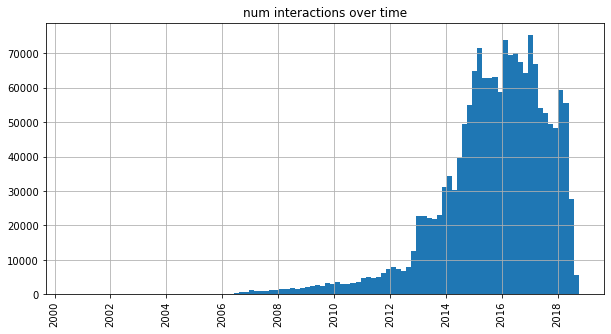

In [17]:
plt.figure(figsize=(10,5))
events_df['TIMESTAMP'].astype('datetime64[s]').hist(bins=100,xrot=90)
plt.title('num interactions over time')

In [18]:
test_start_date  = [2018,2,1]
test_start  = dt.datetime(*test_start_date).timestamp()
train_df=events_df[events_df['TIMESTAMP']<test_start]
test_df=events_df[events_df['TIMESTAMP']>=test_start]
warm_user=set(train_df['USER_ID'].unique())&set(test_df['USER_ID'].unique())
print('number of train users:{}'.format(len(train_df['USER_ID'].unique())))
print('number of warm test users who have non-empty interaction in TRAIN:{}'.format(len(warm_user)))
print('number of total users in TEST:{}, removed {} cold users from TEST'.format(len(test_df['USER_ID'].unique()),len(test_df['USER_ID'].unique())-len(warm_user)))
test_df=test_df[test_df['USER_ID'].isin(warm_user)]

number of train users:226200
number of warm test users who have non-empty interaction in TRAIN:51254
number of total users in TEST:55612, removed 4358 cold users from TEST


将处理后的训练交互数据保存到 CSV 中

In [19]:
interactions_filename = "interactions.csv"
train_df.to_csv(interactions_filename, index=False)

### 获取 Personalize API 模型 JSON 和 Personalize Boto3 客户端

In [21]:
# Copy personalize.normal.json to the same directly
# the file can be found from drive: https://drive.corp.amazon.com/documents/hydro@/personalize.normal.json
!aws configure add-model --service-model file://`pwd`/personalize.normal.json --service-name personalize

In [99]:
import boto3
import json
import numpy as np
import pandas as pd
import time

personalize = boto3.client(service_name = 'personalize')
s3 =boto3.client('s3')

### 辅助函数
以下辅助函数稍后将在该笔记本中使用。

In [23]:
def print_s3_file_content(bucket, key, limit=None):
    obj = s3.get_object(Bucket=bucket, Key=key)

    i = 0
    for line in obj['Body'].read().decode("utf-8").split("\n"):
        print(line)
        i+=1
        if limit is not None and i > limit:
            break

max_time = time.time() + 3 * 60 * 60 # 3 hours

def wait_for_dataset_group_job(dataset_group_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_dataset_group_response = personalize.describe_dataset_group(
            datasetGroupArn = dataset_group_arn
        )
        status = describe_dataset_group_response["datasetGroup"]["status"]
        print("DatasetGroup: {}".format(status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(60)
        
def wait_for_dataset_import_job(dataset_import_job_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = dataset_import_job_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        print("DatasetImportJob: {}".format(status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(120)
            
def wait_for_solution_version_job(solution_version_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_solution_version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = describe_solution_version_response["solutionVersion"]["status"]
        print("SolutionVersion: {}".format(status))

        start = describe_solution_version_response["solutionVersion"]["creationDateTime"]
        end = describe_solution_version_response["solutionVersion"]["lastUpdatedDateTime"]
        if status == "ACTIVE":
            print("Time took: {}".format(end - start))
            break
        if status == "CREATE FAILED":
            print("Time took: {}".format(end - start))
            print("Job Failed: {}".format(describe_solution_version_response["solutionVersion"]["failureReason"]))
            break

        time.sleep(180)
        
def wait_for_batch_segment_job(batch_segment_job_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_job_response = personalize.describe_batch_segment_job(
            batchSegmentJobArn = batch_segment_job_arn
        )
        status = describe_job_response["batchSegmentJob"]["status"]
        print("Batch Segment Job: {}".format(status))

        start = describe_job_response["batchSegmentJob"]["creationDateTime"]
        end = describe_job_response["batchSegmentJob"]["lastUpdatedDateTime"]
        if status == "ACTIVE":
            print("Time took: {}".format(end - start))
            break
        if status == "CREATE FAILED":
            print("Time took: {}".format(end - start))
            print("Job Failed: {}".format(describe_job_response["batchSegmentJob"]["failureReason"]))
            break

        time.sleep(180)
        
        
def import_dataset(job_name, dataset_arn, data_s3_url, role_arn):
    max_time = time.time() + 3 * 60 * 60
    dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = job_name,
        datasetArn = dataset_arn,
        dataSource = {
            "dataLocation": data_s3_url 
        },
        roleArn = role_arn
    )

    dataset_import_job_arn = dataset_import_job_response['datasetImportJobArn']
    print(dataset_import_job_arn)
    
    wait_for_dataset_import_job(dataset_import_job_arn)

# Item affinity 配方

Item affinity 配方将推荐可能与给定项目交互的用户。
### 注意：
* 请跳至步骤 2。如果已创建了数据集组，请创建解决方案
* 请跳至步骤 3。如果已训练了解决方案版本，并且希望在没有筛选器的情况下进行查询，请创建批量细分
* 请跳至步骤 4。如果已训练了解决方案版本，并且希望使用筛选器进行测试，请创建筛选器

## 1. 创建数据集组、数据集和上载数据集

### 1.1 创建架构

In [24]:
interactions_schema = {
  "type": "record",
  "name": "Interactions",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "USER_ID",
      "type": "string"
    },
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    {
      "name": "TIMESTAMP",
      "type": "long"
    }
  ],
  "version": 1
}

create_schema_response = personalize.create_schema(
    name = "notebook-amazon-grocery-meta-interaction-schema-demo",
    schema = json.dumps(interactions_schema)
)

interactions_schema_arn = create_schema_response['schemaArn']
print(interactions_schema_arn)

arn:aws:personalize:us-west-2:144386903708:schema/notebook-amazon-grocery-meta-interaction-schema-demo


In [25]:
items_schema = {
  "type": "record",
  "name": "Items",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    {
      "name": "DESCRIPTION",
      "type": [
        "string",
        "null"
      ],
      "textual": True
    }
  ],
  "version": 1
}

create_schema_response = personalize.create_schema(
    name = "notebook-amazon-grocery-meta-item-schema-demo",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(items_schema_arn)

arn:aws:personalize:us-west-2:144386903708:schema/notebook-amazon-grocery-meta-item-schema-demo


### 1.2 创建数据集组

In [26]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "notebook-amazon-grocery-meta-demo"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(dataset_group_arn)

arn:aws:personalize:us-west-2:144386903708:dataset-group/notebook-amazon-grocery-meta-demo


#### 等待数据集组状态变为 ACTIVE

In [27]:
wait_for_dataset_group_job(dataset_group_arn)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### 1.3 创建数据集

In [28]:
create_dataset_response = personalize.create_dataset(
    name = "interactions",
    datasetType = "INTERACTIONS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(interactions_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/notebook-amazon-grocery-meta-demo/INTERACTIONS


In [29]:
create_dataset_response = personalize.create_dataset(
    name = "items",
    datasetType = "ITEMS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(items_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/notebook-amazon-grocery-meta-demo/ITEMS


### 1.4 创建数据集导入作业

In [30]:
# Determine the current S3 region where this notebook is being hosted in SageMaker.
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-west-2


#### 1.4.1 [如果已经创建，则可选] 创建 S3 存储桶

In [31]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + "personalize-user-segmentation-demo"
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
    )

144386903708-us-west-2-personalize-user-segmentation-demo


#### 将仅包含说明的交互和项目以 CSV 格式上载到 S3

In [32]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_filename)
boto3.Session().resource('s3').Bucket(bucket_name).Object(items_with_desc_only_filename).upload_file(items_with_desc_only_filename)

#### 1.4.2 [如果已经附加，则可选] 附加存储桶策略，以便 Personalize 可以访问它

In [33]:
s3 = boto3.client("s3")
bucket = bucket_name
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket",
                "s3:PutObject"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}
# uncomment if this policy has not been attached to the bucket
s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '1W51Y6AMS72DV9QW',
  'HostId': 'O4tTBmulKx+gz0htR7Xf7/PtBLYAB64BA+elATp6utWjbU0BmLy5Mb/O3hd/UfOHVaVJdRnsG8U=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'O4tTBmulKx+gz0htR7Xf7/PtBLYAB64BA+elATp6utWjbU0BmLy5Mb/O3hd/UfOHVaVJdRnsG8U=',
   'x-amz-request-id': '1W51Y6AMS72DV9QW',
   'date': 'Fri, 26 Nov 2021 03:26:11 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

#### 1.4.3 [如果已经创建，则可选] 创建具有 Personalize 完全访问权限和 S3 完全访问权限的 Personalize 角色

In [34]:
iam = boto3.client("iam")
role_name = "MyNotebookPersonalizeRoleDemo"+account_id
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::144386903708:role/MyNotebookPersonalizeRoleDemo144386903708


### 1.5 创建数据集导入作业

#### 1.5.1 使用 1.4.2 中指定的角色和 1.4.3 中准备的数据创建导入作业

In [ ]:
interactions_s3_url = "s3://"+bucket_name+"/"+interactions_filename
import_dataset("notebook-ag-inters-import", interactions_dataset_arn, interactions_s3_url, role_arn)

In [ ]:
items_s3_url =        "s3://"+bucket_name+"/"+items_with_desc_only_filename
import_dataset("notebook-items-textual-import", items_dataset_arn, items_s3_url, role_arn)

## 2. 创建解决方案

#### 2.1 选择 item-affinity 配方

In [38]:
item_user_recipe = 'arn:aws:personalize:::recipe/aws-item-affinity'

### 2.2 创建解决方案

In [39]:
create_solution_response = personalize.create_solution(
    name = "item-affinity-amazon-grocery-meta-demo",
    datasetGroupArn = dataset_group_arn,
    recipeArn = item_user_recipe,
)
solution_arn = create_solution_response['solutionArn']

In [40]:
personalize.describe_solution(solutionArn = solution_arn)

{'solution': {'name': 'item-affinity-amazon-grocery-meta-demo',
  'solutionArn': 'arn:aws:personalize:us-west-2:144386903708:solution/item-affinity-amazon-grocery-meta-demo',
  'performHPO': False,
  'performAutoML': False,
  'recipeArn': 'arn:aws:personalize:::recipe/aws-item-affinity',
  'datasetGroupArn': 'arn:aws:personalize:us-west-2:144386903708:dataset-group/notebook-amazon-grocery-meta-demo',
  'status': 'ACTIVE',
  'creationDateTime': datetime.datetime(2021, 11, 26, 3, 38, 23, 645000, tzinfo=tzlocal()),
  'lastUpdatedDateTime': datetime.datetime(2021, 11, 26, 3, 38, 23, 645000, tzinfo=tzlocal())},
 'ResponseMetadata': {'RequestId': 'e0d5e15c-7a5d-42b9-a37a-a30500d9afe7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 26 Nov 2021 03:38:24 GMT',
   'x-amzn-requestid': 'e0d5e15c-7a5d-42b9-a37a-a30500d9afe7',
   'content-length': '475',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### 2.3 创建解决方案版本

In [41]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)
solution_version_arn = create_solution_version_response['solutionVersionArn']
print(solution_version_arn)

arn:aws:personalize:us-west-2:144386903708:solution/item-affinity-amazon-grocery-meta-demo/e27b6a08


#### 等待解决方案版本状态变为 ACTIVE

In [43]:
wait_for_solution_version_job(solution_version_arn)

SolutionVersion: ACTIVE
Time took: 2:15:34.850000


### 2.4 获取指标
注意：这些指标是 Amazon Personalize 的离线指标，用于跨解决方案版本评估结果。这些指标不应与我们将从预处理数据时构建的测试数据集中获得的指标相混淆。

In [44]:
get_solution_metrics_response = personalize.get_solution_metrics(solutionVersionArn=solution_version_arn)
print(get_solution_metrics_response['metrics'])

{'coverage': 0.6835, 'hits_at_1_percent': 0.323, 'recall_at_1_percent': 0.0752}


## 3. 创建批量细分作业
我们对在测试集中随机选择的 500 个项目运行 aws-item-affinity 解决方案，以查询 2262 个用户（数据集中 1% 的用户）的列表。然后，我们使用测试集来评估 2262 个用户在测试期间购买项目的频率。为了进行比较，我们还评估了 2262 位最活跃用户在测试期间购买项目的频率。

### 3.1 从测试集 groundtruth 准备输入查询数据

In [45]:
groundtruth=test_df.groupby('ITEM_ID')['USER_ID'].unique()
#sample 500 items from test data as test queries
test_labels=groundtruth.sample(n=500,random_state=10)
test_labels.reset_index()[['ITEM_ID']].rename(columns={'ITEM_ID':'itemId'}).to_json('query-amazon-grocery.json',orient='records',lines=True)
test_labels=test_labels.to_frame('target_users')
test_labels

,target_users
ITEM_ID,
B00DIBYDCY,[A12E83IRM13GQW]
B007JCXVF8,"[A171SOU49WBY9Q, A1NBWNGTFAVQ35, A2BDPU4K4RIQH..."
B00IEGNPTA,[A1QBYVDQ0V6HAR]
B00FQR6IDU,[A1Y7YWTOLRWTDJ]
B00OLDP5KC,[A3GAHEYWEGLYS1]
...,...
B01F192YFI,[A28RBB909ZNR8F]
B00099XLEE,[A2R9Z7VI5GAQGR]
B00V8B5RXK,[ANW9IX7324JYR]


In [46]:
# example json lines in the input file:
# {"itemId": "1"}
# {"itemId": "2"}
# {"itemId": "3"}
# ...
batch_file_name = 'query-amazon-grocery.json'
boto3.Session().resource('s3').Bucket(bucket_name).Object(batch_file_name).upload_file(batch_file_name)
batch_input_path = "s3://"+bucket_name+"/"+batch_file_name
batch_output_path = "s3://"+bucket_name+"/output/"
print_s3_file_content(bucket=bucket_name, key=batch_file_name,limit=3)
# these are the file contents

{"itemId":"B00DIBYDCY"}
{"itemId":"B007JCXVF8"}
{"itemId":"B00IEGNPTA"}
{"itemId":"B00FQR6IDU"}


**让我们打印唯一用户的数量**

In [47]:
topk=len(train_df['USER_ID'].unique())//100
topk

2262

### 3.2 创建批量细分作业

In [48]:
# change the jobName if already exists
create_batch_segment_response = personalize.create_batch_segment_job(
    jobName = "notebook-query-demo-500",
    solutionVersionArn = solution_version_arn,
    numResults = topk,
    jobInput =  {
        "s3DataSource": {
            "path": batch_input_path
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": batch_output_path
        }
    },
    roleArn = role_arn # defined in Step 1.4.2
    )

batch_segment_job_arn = create_batch_segment_response['batchSegmentJobArn']
print(batch_segment_job_arn)

arn:aws:personalize:us-west-2:144386903708:batch-segment-job/notebook-query-demo-500


In [50]:
wait_for_batch_segment_job(batch_segment_job_arn)

Batch Segment Job: ACTIVE
Time took: 0:33:11.414000


#### 计算测试数据的评估指标

In [51]:
def get_hit_recall_k(k, topk, grndtruth):
    """ compare topk and gnd; 
    """
    df = grndtruth.join(topk.reindex(grndtruth.index, fill_value=[]).to_frame('pred'))
    hit = df.apply(lambda x: len(set(x['pred']).intersection(x['target_users'])),axis=1)
    recall = hit / grndtruth['target_users'].apply(lambda x:min(len(x),k))
    hit_recall = pd.DataFrame({'hit': hit, 'recall': recall}).rename(columns={'hit':'hits @ top-{}'.format(k),'recall':'recall @ top-{}'.format(k)}) # item by metric_name
    return hit_recall

In [52]:
batch_file_name = "query-amazon-grocery.json"
output_file_name_s3 = batch_output_path+batch_file_name+".out"
output=pd.read_json(output_file_name_s3, lines = True)
prediction=output.apply(lambda x:pd.Series({'ITEM_ID':x['input']['itemId'],'USER_ID':x['output']['usersList']}),axis=1).set_index('ITEM_ID')['USER_ID']
output.sample(3)

,input,output,error
156,{'itemId': 'B00D97LWTE'},"{'usersList': ['A3Q4NULWZU3RI', 'A1GGOC9PVDXW7...",NaN
99,{'itemId': 'B00N3F2U5W'},"{'usersList': ['AZM4OOWFEFPS7', 'A1D4FARNGLSPG...",NaN
53,{'itemId': 'B00S7NAY0I'},"{'usersList': ['A3NLJZI5NEOT0K', 'ALQ4USPEQ9L5...",NaN


#### 首先，我们评估 item-affinity 解决方案的性能：

In [53]:
print('Test metrics for Personalized-item-affinity')
get_hit_recall_k(topk,prediction,test_labels).mean()

Test metrics for Personalized-item-affinity


hits @ top-2262      0.266000
recall @ top-2262    0.120578
dtype: float64

#### 为了进行比较，我们评估了 2262 名最活跃用户购买我们所查询的项目的频率。

In [54]:
#implement popularity baseline
pop_users=train_df.groupby('USER_ID')['TIMESTAMP'].count()
prediction_pop=pd.Series([pop_users.sort_values(ascending=False).index.values[:topk].tolist()
                            for _ in range(len(test_labels))],
                        index=test_labels.index)
print('Test metrics for Popularity baseline')
get_hit_recall_k(topk,prediction_pop,test_labels).mean()

Test metrics for Popularity baseline


hits @ top-2262      0.072000
recall @ top-2262    0.032023
dtype: float64

我们可以看到，项目关联解决方案在识别将购买给定项目的用户方面的性能提高了 4 倍！

## 编辑检查
我们还想检查一些例子，看看它们是否与我们的编辑判断一致。

In [55]:
import pandas as pd, io
obj = s3.get_object(Bucket=bucket_name,Key=interactions_filename)
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
obj = s3.get_object(Bucket=bucket_name,Key=items_with_desc_only_filename)
df_items = pd.read_csv(io.BytesIO(obj['Body'].read()))

让我们创建一个 json 文件，在其中包含 10 个要查询的项目，并讲过该文件上传到 S3 存储桶。我们还将创建一个输出路径来保存结果。

In [56]:
editorial_test_item_ids = [{"itemId": "0853347867"},{"itemId": "1888861118"},{"itemId": "1888861614"},{"itemId": "B0000CEUSQ"},{"itemId": "B0000CNU3F"},{"itemId": "B0000DBN1H"},{"itemId": "B0000DG5CD"},{"itemId": "B0000TA3SK"},{"itemId": "B0001AVSRI"},{"itemId": "B0005YXXDC"}]
editorial_batch_file_name = 'editorial_test_item_ids.json'
editorial_test_item_ids_sr= pd.Series(editorial_test_item_ids)
editorial_test_item_ids_sr.to_json(editorial_batch_file_name,orient='records',lines=True)
boto3.Session().resource('s3').Bucket(bucket_name).Object(editorial_batch_file_name).upload_file(editorial_batch_file_name)
editorial_batch_input_path = "s3://"+bucket_name+"/"+editorial_batch_file_name
editorial_batch_output_path = "s3://"+bucket_name+"/output/"
print_s3_file_content(bucket=bucket_name, key=editorial_batch_file_name,limit=10)

{"itemId":"0853347867"}
{"itemId":"1888861118"}
{"itemId":"1888861614"}
{"itemId":"B0000CEUSQ"}
{"itemId":"B0000CNU3F"}
{"itemId":"B0000DBN1H"}
{"itemId":"B0000DG5CD"}
{"itemId":"B0000TA3SK"}
{"itemId":"B0001AVSRI"}
{"itemId":"B0005YXXDC"}


让我们为这 10 个项目 ID 创建一个批量细分作业。*请注意，这将需要大约 10 分钟才能运行*

In [58]:
create_batch_segment_response = personalize.create_batch_segment_job(
    jobName = "notebook-query-editorial-demo",
    solutionVersionArn = solution_version_arn,
    numResults = 10,
    jobInput =  {
        "s3DataSource": {
            "path": editorial_batch_input_path
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": editorial_batch_output_path
        }
    },
    roleArn = role_arn 
    )

batch_segment_job_arn = create_batch_segment_response['batchSegmentJobArn']
print(batch_segment_job_arn)

arn:aws:personalize:us-west-2:144386903708:batch-segment-job/notebook-query-editorial-demo


In [59]:
wait_for_batch_segment_job(batch_segment_job_arn)

Batch Segment Job: CREATE IN_PROGRESS
Batch Segment Job: CREATE IN_PROGRESS
Batch Segment Job: ACTIVE
Time took: 0:06:42.365000


**让我们定义一些辅助函数**

In [60]:
def print_query_item_user_len_user_last(itemId, usersList):
    print(df_items.set_index('ITEM_ID').loc[itemId].DESCRIPTION)
    user_list_df = []
    for userId in usersList:
        user_hist = df[df['USER_ID']==userId].join(
            df_items.set_index('ITEM_ID'), on='ITEM_ID'
        ).sort_values('TIMESTAMP', kind='mergesort')
        user_list_df.append([userId,
            len(user_hist)]+user_hist.iloc[-1:-4:-1].DESCRIPTION.apply(lambda x:x.split(',')[0][0:50]).to_list())
    display(pd.DataFrame(user_list_df, columns=['USER_ID','len', 'last purchase','last but 1 purchase','last but 2 purchase']).set_index('USER_ID'))
    
def print_query_item_user_last10(itemId, userId, k=10):
    print(df_items.set_index('ITEM_ID').loc[itemId].DESCRIPTION)
    user_list_df = []
    user_hist = df[df['USER_ID']==userId].join(
            df_items.set_index('ITEM_ID'), on='ITEM_ID'
        ).sort_values('TIMESTAMP', kind='mergesort')
    print('\n'.join(user_hist.iloc[-1:(-1-k):-1].DESCRIPTION.apply(lambda x:x.split(',')[0][0:50]).to_list()))

**让我们检索我们的输出文件并处理它**

In [61]:
editorial_batch_file_name = "editorial_test_item_ids.json"
output_file_name_s3 = batch_output_path+editorial_batch_file_name+".out"
output=pd.read_json(output_file_name_s3, lines = True)
detail=output.apply(lambda x:pd.Series({'ITEM_ID':x['input']['itemId'],'USER_ID':x['output']['usersList']}),axis=1).set_index('ITEM_ID')['USER_ID']
pd.options.display.max_colwidth=250

我们已经对这些项目运行了细分查询，并识别了针对每个项目的前 10 名用户。我们还查询了每个已识别用户的最后 3 个项目。让我们先来看看我们在随附的博客文章中评估的三个项目：

In [62]:
for item in ["B0000CEUSQ","B0000TA3SK","1888861118"]:
    print_query_item_user_len_user_last(
    item,detail.loc[item])

Gingerbread Coffee, 1 lb Whole Bean FlavorSeal Vacuum Bag Bite into a freshly basked Gingerbread Coffee Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.


,len,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,
APHFL4MDJRGWB,35,Dunkin' Donuts Original Blend Ground Coffee,Coffee-Mate Coffee Mix,Folgers Gourmet Selections Coconut Cream Pie Flavo
A13YHYM6FA6VJO,14,Lola Savannah Triple Vanilla Whole Bean,Lola Savannah Vanilla Cinnamon Pecan Whole Bean,Pecan Maple Nut
ANEDXRFDZDL18,46,Orange Flavored Coconut Patties Dipped in Chocolat,SToK Cold-Brew Iced Coffee,SToK Cold-Brew Iced Coffee
A1H3ATRIQ098I7,39,Brew La La Red Velvet Cupcake Coffee,Ola's Exotic Super Premium Coffee Organic Uganda B,Coffee Masters Gourmet Coffee
A3N8JE6CVB5YA4,17,Christopher Bean Coffee Whole Bean Coffee,Christopher Bean Coffee Decaffeinated Whole Bean C,Christopher Bean Coffee Decaffeinated Whole Bean F
A1D4FARNGLSPGW,38,Large Bahamian Rum Cake,Sincerely Nuts Sesame Sticks - One Lb. Bag - Fiber,Kirkland Signature Cashews
A2EUS0XXJUDBLS,24,Christopher Bean Coffee Ground Coffee,Hawaiian Isles Kona Coffee Co. Kona Classic Ground,Dark Chocolate Flavored Coating Chocolate Truffle
A2NLJJVA0IEK2S,21,Coffee Masters Flavored Coffee,Lays 15pk Hickory Sticks Original (47g / 1.6oz per,Albanese Confectionery Sugar Free Gummy Bears
A2LK2DENORQI8S,21,The Bean Coffee Company Organic Holiday Bean (Vani,Lola Savannah Angel Dust Ground,New England Coffee Blueberry Cobbler


Wright's Natural Hickory Seasoning Liquid Smoke, 128 Ounce This seasoning is produced by burning fresh cut hickory chips, then condensing the smoke into a liquid form. The liquid smoke is then scrubbed and filtered to remove all impurities. Modern ovens and condensers are used to ensure consistent quality. This product is used in many top rate restaurants and dinners across the US. Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.


,len,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,
A1MHK19QSCV8SY,41,Hoosier Hill Farm Prague Powder No.1 Pink Curing S,APPLE CIDER VINEGAR,Fleischmann's Instant Dry Yeast 1lb bag Dry Yeast.
A3F7NO1Q3RQ9Y0,24,Yankee Traders Brand Whole Allspice,Aji No Moto Ajinomoto Monosodium Glutamate Umami S,Hoosier Hill Farm Prague Powder No.1 Pink Curing S
A3N7L1ATRNRT8N,18,Hoosier Hill Farm Whole Caraway Seeds 1 lb Caraway,Hoosier Hill Farm Mustard Powder,McCormick Ground Cinnamon
AN1YQBPJ56SVV,27,Frontier Co-op Smoked Paprika Organic,Hoosier Hill Farm Chipotle Morita Powder,Singsong Korean Hot Pepper Coarse Type Powder
A3HLXZUVXPY6FJ,18,NESTLE COFFEE-MATE Coffee Creamer,Spiceology Ground Ancho Chile Powder | All-Natural,Spice Appeal Chipotle Chili Ground
A12MSGE788YU1O,7,Best Naturals Extra Virgin Coconut Oil 1300 mg 180,Wright's Natural Hickory Seasoning Liquid Smoke,20 Seeds Bhut Jolokia chilli Ghost Chilli Ghost Ch
A2U77Z3Z7DC9T9,124,Food to Live Yellow Mustard Seeds (Kosher) 5 Pound,100 Sheets (6.7oz) Dried Kelp Seaweed Nori Raw Uns,SB Oriental Hot Mustard Powder
A2WW9T8EEI8NU4,35,Frontier Garlic Powder,Wolf Chili Without Beans,Crystallized Ginger by D'Allesandro
A386U8H1AC4OI0,11,Colgin Liquid Smoke,Lee Kum Kee Hoisin Sauce,Badia Chili Powder Spice


Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your convenience. You can use these simple yet elegant monogram cake toppers to make a Sweet 16 even sweeter or use them for a wedding cake to make the cake more special.


,len,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,
AC7O52PQ4HPYR,6,Rhinestone Cake Topper Number 7 by other This deli,Rhinestone Cake Topper Number 5 This delicate and,Rhinestone Cake Topper Number 8 by other This deli
A2814L9UEC63JC,14,Oasis Supply Swimming Pool Cake Decorating Kit,SAILOR MOON 8 Piece CUPCAKE Topper Set Featuring 6,Lucky Beckoning Cat Maneki Neko Fortune Japanese K
A3RLEN577P4E3M,23,All About Details Black Happy-75th-birthday Cake T,"Grocery Gourmet Food"" /> Spend the morning with th",Hinterland Trading Five Pack Guatemalan Air Plants
A2XZ57YVN4SLOG,12,Finally 21 Girl - 21st Birthday Cupcake Wrapper an,Lorann Oils Meringue Powder,12 Food Color Chefmaster by US Cake Supply 2.3-Oun
A2XERDJ6I2K38U,19,Wilton Decorator Preferred Green Fondant,Wilton Decorator Preferred Red Fondant,Wilton Decorator Preferred Red Fondant
A35JVJVRFVWGH3,10,Rhinestone Cake Topper Number 1 This delicate and,Skratch Labs Cookie Mix 13.9oz (393g) Wyoming's Wi,Fondarific Cherry Fondant
A275LX4CBRALIX,18,Carma Massa Ticcino - Rolling Fondant,Unflavored Gelatin - 1 lb An odorless,Ultra-Moist Super Chocolate Cake Mix
A1474SH2RB49MP,5,Assorted Snowflake Sugar Decorations Disney Movie,Darice VL3L Mirror Acrylic Initial Letter Cake Top,Edible Snowflakes Sugar Decorations (15 pc).
A2HYNYUT5WAQQD,11,Large Gold 50 th Birthday Wedding Anniversary Numb,Music Notes Edible Cake Border Decoration Edible c,RuiChy Fondant Silicone Cake Decoration Mould Pack


第一个表显示了姜饼咖啡细分查询的结果，这是我们可能想在假期推广的产品。我们识别的大多数用户显然是咖啡饮用者，他们最近购买了咖啡和咖啡奶精。有趣的是，我们查询的是全豆咖啡，而不是研磨咖啡。我们在项目历史记录中看到，在信息可用的情况下，这些用户最近购买了全豆咖啡。

下表显示了对山核桃木烟熏液（一种用于烧烤和腌制培根的调味品）的细分查询。在用户最近购买的烧烤产品中，我们看到了许多不同的杂货产品：烧烤酱、调味料和辣酱。其中两名用户最近购买了布拉格粉末 1 号粉红色固化盐，也是一种用于腌制培根的产品。如果我们依靠规则来识别对烧烤感兴趣的人，这两个用户可能会被遗漏。

我们的第三个示例显示了一个用于蛋糕顶部装饰的细分查询。我们看到，识别的用户不仅是面包师，显然也对装饰烘焙食品感兴趣。我们看到他们最近购买的项目包括其他蛋糕配料、可食用装饰品和软糖（用于雕刻蛋糕的糖衣）。

我们还可以对所有 10 个项目运行相同的查询：

In [63]:
# this prints results for all 10 query items
# for item in detail.index:
#     print_query_item_user_len_user_last(
#     item,detail.loc[item])

## 4. 筛选器
为完整起见，我们展示了一个带有筛选器的示例。

In [65]:
# create_filter_response = personalize.create_filter(
#     name = "notebook-sample-user-filter",
#     datasetGroupArn = dataset_group_arn,
#     filterExpression = "exclude UserId where users.country in (\"England\", \"Japan購入\")"
# )
# filter_arn = create_filter_response['filterArn']
# print(filter_arn)

### 说明：

不筛选：
```
{"input": {"itemId": "1"}, "output": {"usersList": ["61","22","57","72","26","41","33","4","34","43"]}, "error": null}
{"input": {"itemId": "110"}, "output": {"usersList": ["34","72","41","26","21","22","4","61","57","38"]}, "error": null}
{"input": {"itemId": "235"}, "output": {"usersList": ["57","61","33","22","4","34","26","72","8","5"]}, "error": null}
```

筛选器为 `exclude user.Country in 'England' or 'Japan購入'`
```
61         : Japan購入
4, 22, 72  : England
```


# 项目属性关联

接下来，我们将使用相同的 Amazon Prime Pantry 数据来运行项目属性关联配方。这个过程看起来非常熟悉，但是，这一次，我们不是查询特定的项目，而是查询项目元数据中的项目属性。该解决方案将识别非常可能与包含该属性的项目进行交互的用户。

## 1. 创建数据集组、数据集和上载数据集

### 1.1 创建架构

项目属性配方的交互数据架构与我们为项目配方创建的交互数据架构相同，因此我们只需要为元数据创建架构，以包括将用作查询结果的属性的分类特征。我们将包括品牌、主要类别、类别和价格。

In [66]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CATEGORY",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "BRAND",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "MAIN_CAT",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "PRICE",
            "type": [ "null", "float" ],
        }
    ],
    "version": "1.0"
}
create_schema_response = personalize.create_schema(
    name = "amazon-grocery-meta-item-schema-demo",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(items_schema_arn)

arn:aws:personalize:us-west-2:144386903708:schema/amazon-grocery-meta-item-schema-demo


### 1.2 创建数据集组

In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "amazon-grocery-attr-meta-demo"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(dataset_group_arn)

#### 等待数据集组状态变为 ACTIVE

In [68]:
wait_for_dataset_group_job(dataset_group_arn)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### 1.3 创建数据集

In [70]:
create_dataset_response = personalize.create_dataset(
    name = "interactions",
    datasetType = "INTERACTIONS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(interactions_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/amazon-grocery-attr-meta-demo/INTERACTIONS


In [71]:
create_dataset_response = personalize.create_dataset(
    name = "items",
    datasetType = "ITEMS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(items_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/amazon-grocery-attr-meta-demo/ITEMS


### 1.4 创建数据集导入作业

In [72]:
#Lets upload the dataset into S3

boto3.Session().resource('s3').Bucket(bucket_name).Object(items_meta_filename).upload_file(items_meta_filename)
items_s3_url = "s3://"+bucket_name+"/"+items_meta_filename

### 1.5 创建数据集导入作业

#### 1.5.1 使用 1.4.2 中指定的角色和 1.4.3 中准备的数据创建导入作业

In [75]:
import_dataset("notebook-item-attr-inters-import", interactions_dataset_arn, interactions_s3_url, role_arn)

arn:aws:personalize:us-west-2:144386903708:dataset-import-job/notebook-item-attr-inters-import
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE


In [ ]:
import_dataset("notebook-item-attr-meta-import", items_dataset_arn, items_s3_url, role_arn)

arn:aws:personalize:us-west-2:144386903708:dataset-import-job/notebook-item-attr-meta-import
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS


## 2. 创建解决方案

### 2.1 选择 item-affinity 配方

In [78]:
item_attri_user_recipe = 'arn:aws:personalize:::recipe/aws-item-attribute-affinity'

### 2.2 创建解决方案

In [79]:
create_solution_response = personalize.create_solution(
    name = "item-attr-affinity-amazon-grocery-demo",
    datasetGroupArn = dataset_group_arn,
    recipeArn = item_attri_user_recipe,
)
solution_arn = create_solution_response['solutionArn']

In [80]:
personalize.describe_solution(solutionArn = solution_arn)

{'solution': {'name': 'item-attr-affinity-amazon-grocery-demo',
  'solutionArn': 'arn:aws:personalize:us-west-2:144386903708:solution/item-attr-affinity-amazon-grocery-demo',
  'performHPO': False,
  'performAutoML': False,
  'recipeArn': 'arn:aws:personalize:::recipe/aws-item-attribute-affinity',
  'datasetGroupArn': 'arn:aws:personalize:us-west-2:144386903708:dataset-group/amazon-grocery-attr-meta-demo',
  'status': 'ACTIVE',
  'creationDateTime': datetime.datetime(2021, 11, 28, 22, 24, 39, 700000, tzinfo=tzlocal()),
  'lastUpdatedDateTime': datetime.datetime(2021, 11, 28, 22, 24, 39, 700000, tzinfo=tzlocal())},
 'ResponseMetadata': {'RequestId': '8bd97721-a8c3-4c70-8820-4c3131e600a6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 28 Nov 2021 22:24:41 GMT',
   'x-amzn-requestid': '8bd97721-a8c3-4c70-8820-4c3131e600a6',
   'content-length': '477',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### 2.3 创建解决方案版本

In [81]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)
solution_version_arn = create_solution_version_response['solutionVersionArn']
print(solution_version_arn)

arn:aws:personalize:us-west-2:144386903708:solution/item-attr-affinity-amazon-grocery-demo/9bb1bcbb


#### 等待解决方案版本状态变为 ACTIVE

In [83]:
wait_for_solution_version_job(solution_version_arn)

SolutionVersion: ACTIVE
Time took: 3:41:37.548000


### 2.4 获取指标

In [84]:
get_solution_metrics_response = personalize.get_solution_metrics(solutionVersionArn=solution_version_arn)
print(get_solution_metrics_response['metrics'])

{'coverage': 0.2886, 'hits_at_1_percent': 19.7648, 'recall_at_1_percent': 0.0674}


## 3. 创建批量细分作业

### 3.1 准备输入查询数据

让我们来看几个查询示例

In [85]:
attr_query='{"itemAttributes":"ITEMS.CATEGORY = \\"Candy & Chocolate\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Coffee, Tea & Cocoa\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Dried Vegetables\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Starbucks\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Jelly Belly\\""}'
attr_query

'{"itemAttributes":"ITEMS.CATEGORY = \\"Candy & Chocolate\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Coffee, Tea & Cocoa\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Dried Vegetables\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Starbucks\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Jelly Belly\\""}'

In [86]:
with open("query-amazon-grocery-attribute.json", "w") as f:
    f.write(attr_query)

In [87]:
pd.read_json("query-amazon-grocery-attribute.json",lines = True)

,itemAttributes
0,"ITEMS.CATEGORY = ""Candy & Chocolate"""
1,"ITEMS.CATEGORY = ""Coffee, Tea & Cocoa"""
2,"ITEMS.CATEGORY = ""Dried Vegetables"""
3,"ITEMS.BRAND = ""Starbucks"""
4,"ITEMS.BRAND = ""Jelly Belly"""


In [88]:
batch_file_name = 'query-amazon-grocery-attribute.json'
boto3.Session().resource('s3').Bucket(bucket_name).Object(batch_file_name).upload_file(batch_file_name)
batch_input_path = "s3://"+bucket_name+"/"+batch_file_name
batch_output_path = "s3://"+bucket_name+"/output/"
print_s3_file_content(bucket=bucket_name, key=batch_file_name,limit=10)
# these are the file contents

{"itemAttributes":"ITEMS.CATEGORY = \"Candy & Chocolate\""}
{"itemAttributes":"ITEMS.CATEGORY = \"Coffee, Tea & Cocoa\""}
{"itemAttributes":"ITEMS.CATEGORY = \"Dried Vegetables\""}
{"itemAttributes":"ITEMS.BRAND = \"Starbucks\""}
{"itemAttributes":"ITEMS.BRAND = \"Jelly Belly\""}


### 3.2 创建批量细分作业
请注意，我们将结果限制为每个细分作业 10 个用户

In [90]:
# change the jobName if already exists
create_batch_segment_response = personalize.create_batch_segment_job(
    jobName = "amazon-grocery-attribute-demo",
    solutionVersionArn = solution_version_arn,
    numResults = 10,
    jobInput =  {
        "s3DataSource": {
            "path": batch_input_path
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": batch_output_path
        }
    },
    roleArn = role_arn
    )

batch_segment_job_arn = create_batch_segment_response['batchSegmentJobArn']
print(batch_segment_job_arn)

arn:aws:personalize:us-west-2:144386903708:batch-segment-job/amazon-grocery-attribute-demo


In [94]:
wait_for_batch_segment_job(batch_segment_job_arn)

Batch Segment Job: ACTIVE
Time took: 0:46:50.477000


### 3.3 目测结果

我们可以再次目测结果，看看它们是否与我们的编辑判断一致。我们运行 5 个查询。前三个查询将针对"Candy & Chocolate"、"Coffee, Tea & Cocoa"以及"Dried Vegetables"类别。接下来的两个查询将基于"Starbucks"和"Jelly Belly"品牌。对于每个查询，我们将搜索 10 个用户并打印他们最近的 5 次购买，以查看他们是否符合我们的预期。

In [95]:
batch_file_name = 'query-amazon-grocery-attribute.json'
batch_output_path = "s3://"+bucket_name+"/output/"+batch_file_name+".out"

output=pd.read_json(batch_output_path, lines = True)
detail=output.apply(lambda x:pd.Series({'query':x['input']['itemAttributes'],'USER_ID':x['output']['usersList'][0:10]}),axis=1)
detail['Attribute_type']=detail['query'].apply(lambda x:x.split(' = ')[0].split('.')[1])
detail['Attribute_value']=detail['query'].apply(lambda x:x.split(' = ')[1].strip('"'))
detail[['Attribute_type','Attribute_value','USER_ID']]

,Attribute_type,Attribute_value,USER_ID
0,CATEGORY,Candy & Chocolate,"[A2OJCTT5WLB2HR, AWOLMIWF4MJZI, A2JV72VRGJ72Q3, A2R819E0C80FXW, A11T807LX2EF00, AKKDQAA03M9NH, A72BDEVIOBZRO, A12BTR2MVK2BR5, AEKP7A8H094IG, A176ZM97SEMIR4]"
1,CATEGORY,"Coffee, Tea & Cocoa","[A1LAJUIT0GEKQ1, A9WMK10TEUNAY, A30SAL8NKD9MTN, A3SV4DQ288XPCU, A3Q2G7GDHO5S5C, ASXR713XF62FO, AHWRHD316AFXM, A3CZTYO4HU5X62, AQMSEHIO1A5SA, AINGNE1J86KTH]"
2,CATEGORY,Dried Vegetables,"[AWM9DF2UPCLKZ, A37UVOOY0U44HK, A1EQ5G6Q41RNZY, AB2YZA2HLY75H, A1AV4IGPFXVHPH, A1L3PBI5E6ON82, A1DBSZIM8ETOOC, A3GDJ6ZAYUA8XI, A27U28CZXVJP3P, A2UOW4RNW59W8S]"
3,BRAND,Starbucks,"[A1FRYXDQJ66R45, A3LWV4B2ZTBDQ0, A1XKXHUUHKCBZ3, A3CLV7MN1YYES6, A2RXT4TK1VHHJY, A17HWBGWWR3AK2, A3AGQAXTX6VRJ3, A1G6XMQ7M3NTOM, A2GI6B0IEGMZUN, A2UE90SLOT9LND]"
4,BRAND,Jelly Belly,"[A27K45M7G0IHPN, A2O1AZ59TMNLJQ, AJK7ZHBJS7HBL, A325EVMUTLRF22, AB9MK8L0HWRAG, A26QUS2F52TCO5, A38RUWO3OQ47D4, A10V87VADEF4MG, ATV2QZ3VQU0ED, A3F7KH5X7OVC94]"


**让我们定义一些辅助函数**

In [96]:
obj = s3.get_object(Bucket=bucket_name,Key=interactions_filename)
df2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
attr2item={}
item2attr2={}
meta=meta.fillna('nan')
for attr_type in ['CATEGORY','BRAND','MAIN_CAT']:
    item2attr2[attr_type]=meta[attr_type].apply(lambda x:str(x).split('|')).explode()
    attr2item[attr_type]=item2attr2[attr_type].reset_index().set_index(attr_type)
def print_analysis(attribute_type, attribute_value, usersList):
    print('Recommended top 10 users for {}:{}'.format(attribute_type, attribute_value))
    user_list_df = []
    for userId in usersList:
        user_hist = df2[df2['USER_ID']==userId].join(
            meta, on='ITEM_ID'
        ).sort_values('TIMESTAMP', kind='mergesort',ascending=False)
#         print('last 5 purchases of user {}'.format(userId))
#         display(user_hist.head(5))
        past_count=item2attr2[attribute_type].loc[user_hist['ITEM_ID'].to_list()].value_counts()
        if not attribute_value in past_count.index:
            past_count.loc[attribute_value]=0
        user_list_df.append([userId,
            len(user_hist),past_count.loc[attribute_value]]+user_hist.iloc[-1:-4:-1].DESCRIPTION.apply(lambda x:x.split(',')[0][0:50]).to_list())
    display(pd.DataFrame(user_list_df, columns=['USER_ID','history_len','num_visit_of_queried_attribute' ,'last purchase','last but 1 purchase','last but 2 purchase']).set_index('USER_ID'))
    print('=======================================================================================')
detail2=detail.set_index(['Attribute_type','Attribute_value'])

**让我们分析一个类别和一个品牌**

通过取消注释下面的代码，您可以随意分析更多内容

In [97]:
print_analysis('CATEGORY', 'Dried Vegetables', detail2.loc[('CATEGORY', 'Dried Vegetables'),'USER_ID'])

Recommended top 10 users for CATEGORY:Dried Vegetables


,history_len,num_visit_of_queried_attribute,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,,
AWM9DF2UPCLKZ,38,1,Eat Natural Almond Apricot Bar with Yogurt Coating,Emperor's Kitchen Organic Pumpkin Seeds,Robinsons Barley Water
A37UVOOY0U44HK,7,1,Karen's Naturals Just Tomatoes,Karen's Naturals Just Tomatoes,Japan Kracie Happy kitchen Decoration cake KIT DIY
A1EQ5G6Q41RNZY,38,0,Wheat Thins Smoky BBQ Snacks,Buffalo Bob's Venison Beef Peppered Jerky 3 Pack s,Buffal Bob's Barbequed Flavor Alligator Jerky 3 Pa
AB2YZA2HLY75H,6,1,Hinterland Trading Air Plant Collector's Edition S,Assorted Japanese Junk Food Snack Dagashi Economic,Tesla's Tiny Twist Pops - 48-Piece Jar (Pink) Take
A1AV4IGPFXVHPH,16,0,GreenMax Boba Milk Tea Powder 24.5 Oz - Green Tea,Monin - Lavender Syrup,E-Fa Brand Bubble Tea Black Tapioca Pearl 2.2LB E-
A1L3PBI5E6ON82,7,1,Just Tomatoes Etc. Just Peas -- 8 oz Absolutely no,Karen's Naturals Organic Just Apples,Karen's Naturals Just Peas
A1DBSZIM8ETOOC,6,1,Karen's Naturals Just Peas,Garden of Life Raw Organic Protein Unflavored Powd,Karen's Naturals Just Tomatoes
A3GDJ6ZAYUA8XI,5,1,Wild Ride Beef Jerky Cowboy Strips,Primal Strips Meatless Vegan Jerky-Variety Gift Pa,Karen's Naturals Just Peas
A27U28CZXVJP3P,7,1,Kind Bars,KIND Bars,KIND Bars


In [98]:
print_analysis('BRAND', 'Starbucks', detail2.loc[('BRAND', 'Starbucks'),'USER_ID'])

Recommended top 10 users for BRAND:Starbucks


,history_len,num_visit_of_queried_attribute,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,,
A1FRYXDQJ66R45,17,5,Mayfair Sales Select Brands Candy Mix,Swiss Miss Keurig K-cups Milk Chocolate Hot Cocoa,Laffy Taffy Assorted Candy Jar
A3LWV4B2ZTBDQ0,8,7,Davidson's Tea Bulk,Starbucks Tribute0174; Blend,Starbucks Anniversary Blend Whole Bean Coffee - Sp
A1XKXHUUHKCBZ3,7,6,Ener G Foods - Bread Brown Rice Yeast Free 19 Oz.,2018 Starbucks Xmas Blend Ground Coffee - 1 Pound,Starbucks Christmas Blend Espresso Roast 1lb A tim
A3CLV7MN1YYES6,10,7,Starbucks VIA Ready Brew Coffee,Japanese Kit Kat Matcha Green Tea Flavor | Sweetne,ZonePerfect Nutrition Snack Bars
A2RXT4TK1VHHJY,18,6,Sparkling Ice Fruit Blends,Stretch Island Fruit Leather Variety Pack 48-Count,Naked Variety Pack Juice Smoothie 8 Mighty Mango
A17HWBGWWR3AK2,15,7,PALMETTO FARMS Stone Ground Yellow Grits,Starbucks House Blend,Starbucks House Blend Medium Roast Coffee Keurig K
A3AGQAXTX6VRJ3,11,5,Tassimo Cappuccino Creamer,Braun 67000-5PK Tassimo Starbucks House Blend,Carte Noir Kenya
A1G6XMQ7M3NTOM,20,4,Mars Real Chocolate Mixed Singles,Lipton K-Cup Packs,Caza Trail Tea
A2GI6B0IEGMZUN,8,2,Cayenne Pepper - 10 Lb Bag Our Ground Cayenne Pepp,Reed's Original Ginger Candy Chews,LARABAR uber


## 附加测试

In [ ]:
# print_analysis('CATEGORY', 'Candy & Chocolate', detail2.loc[('CATEGORY', 'Candy & Chocolate'),'USER_ID'])
# print_analysis('CATEGORY', 'Coffee, Tea & Cocoa', detail2.loc[('CATEGORY', 'Coffee, Tea & Cocoa'),'USER_ID'])
# print_analysis('BRAND', 'Jelly Belly', detail2.loc[('BRAND', 'Jelly Belly'),'USER_ID'])